# Actualization Criteria and Self-Consistent Mean-Field Projections

In this tutorial, we will build upon the concepts introduced in the previous tutorial, where we explored different actualization criteria for Adaptive Max-Ent. Notably, we discovered that the **Partial Sum criterion** provides the tightest control over errors, in contrast to the **Lieb-Robinson criterion**, which is lestightnt.  

However, as the complexity of the bases involved in the actualization g linearly with the number of actualizations and with the depth of the basis, $\ell$rows, managing this complexity becomes critical. To address this challenge, a Self-Consistent **Mean-Field (MF) projection** is applied, to reduce and organize the basis while retaining its essential features.  

In this tutorial, we will continue the discussion while maintaining the same initial conditions for the system.  

### Objectives:  

We will introduce two examples of **MF-aided Adaptive Max-Ent simulations**:  
1. The basis of observables is constructed as a **$m_0$-body projected Hierarchical Basis**, where the projection ensures that all elements of the basis remain manageable.  
2. We will demonstrate how Mean-Field projections enable efficient simulations while preserving the accuracy of the Adaptive Max-Ent scheme.  


In [1]:
import sys 
path= '../'
sys.path.insert(1, path) 

### long term ev 
import matplotlib.pyplot as plt
import numpy as np

# Configuration du style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,        # Taille de police
    'axes.labelsize': 14,   # Taille des labels des axes
    'axes.titlesize': 16,   # Taille des titres
    'legend.fontsize': 12,  # Taille des légendes
    'xtick.labelsize': 12,  # Taille des labels des ticks sur l'axe X
    'ytick.labelsize': 12,  # Taille des labels des ticks sur l'axe Y
    'font.family': 'serif', # Police de type "serif" pour un rendu professionnel
    'axes.linewidth': 1.5,  # Largeur des bordures des axes
    'grid.alpha': 0.5       # Transparence des grilles
})

import numpy as np
import scipy.linalg as linalg
import pickle
from datetime import datetime

import qutip as qutip
from typing import Callable, Optional, Tuple
from scipy.optimize import root, fsolve


from IPython.display import display_latex
from alpsqutip.geometry import graph_from_alps_xml, list_graph_in_alps_xml
from alpsqutip.alpsmodels import list_operators_in_alps_xml,model_from_alps_xml
from alpsqutip.utils import eval_expr
from alpsqutip.model import SystemDescriptor
from alpsqutip import restricted_maxent_toolkit as me ## custom library including basic linear algebra functions 
from alpsqutip.proj_evol import safe_exp_and_normalize ## function used to safely and robustly map K-states to states
from alpsqutip.operators.states.meanfield import one_body_from_qutip_operator, project_to_n_body_operator, self_consistent_quadratic_mfa
## functions used for Mean-Field projections



def lieb_robinson_speed(parameters):
    """Compute the Lieb Robinson speed from the parameters"""
    
    f_factor=np.real(max(np.roots(np.poly1d([1, 0, 
                                             -(parameters['Jx']*parameters['Jy']+
                                               parameters['Jx']*parameters['Jy']+
                                               parameters['Jy']*parameters['Jz']), 
                                             -2*parameters['Jx']*parameters['Jy']*parameters['Jz']])
                                 )
                        )
                    )
    chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
    return 4*f_factor*chi_y

models_lib_file = "../alpsqutip/lib/models.xml"
lattice_lib_file = "../alpsqutip/lib/lattices.xml"


# Load the set of previous simulations

In [2]:
# Here we store the results of the simulations
try:
    with open("simulaciones.pkl", "br") as in_file:
        simulations = pickle.load(in_file)

    with open(f"simulaciones_{str(datetime.now())}.bkp", "bw") as out_file:
        pickle.dump(simulations, out_file)
except:
    simulations = {}


# Define the system and objects required for the simulation

In [3]:
params={}

params['size']=7
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']
params["phi0"] = np.array([.0, .25, .25, -10.])    # No podemos ir más allá de |phi|< 10, 
                                                   # ya que la matriz de Gram se hace singular. 

vLR = lieb_robinson_speed(params)


system=SystemDescriptor(
    model=model_from_alps_xml(models_lib_file, "spin"),
    graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L":params['size'], "a":1}),
    parms={"h":0,"J":params['Jx']}
)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

H = (params['Jx']*sum(sx_ops[i]*sx_ops[i+1] for i in range(params['size']-1)) + params['Jy']*sum(sy_ops[i]*sy_ops[i+1] for i in range(params['size']-1))
     +params['Jz']*sum(sz_ops[i]*sz_ops[i+1] for i in range(params['size']-1)))
idop=system.site_operator("identity", sites[0])

## Define the basis and the initial state

In [4]:
HBB0=[idop, system.site_operator('Sx', '1[0]'), system.site_operator('Sy', '1[0]'), system.site_operator('Sz', '1[0]')]

phi0 = params["phi0"]
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
phi0[0] = np.log(sigma0.tr())
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
[(sigma0 * op).tr() for op in sz_ops] 

[0.49964270571677594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Define the observables we are going to track

In [5]:
OBSERVABLES = {
"obs_SzA": (.5*qutip.tensor(qutip.sigmaz(),qutip.qeye(2),qutip.qeye(2))+
            .5*qutip.tensor(qutip.qeye(2),qutip.sigmaz(),qutip.qeye(2))+
            .5*qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.sigmaz()),
            [i for i in range(0,3)]
           ),
"obs_Sx3Sx4": ((sx_ops[2]*sy_ops[3]).to_qutip(), None)
}




timespan=np.linspace(.0, 650.1/vLR, 650)

def estimate_error_by_partial_sum(phi_local, ws):
    return me.m_th_partial_sum(phi=phi_local, m=2) / me.m_th_partial_sum(phi=phi_local, m=0)

def estimate_error_by_weights(phi, ws):
    return sum(abs(phi_a*w_a) for phi_a, w_a in zip(phi,ws))


# Choose the error estimator
# estimate_error = estimate_error_by_weights
estimate_error = estimate_error_by_partial_sum

## Check consistency and get the exact evolution 
* Verify that the parameters coincides with the parameters stored in the previous run. 
* Run the exact simulation if needed. 

In [6]:
## exact dynamics
############# Uncomment the next line to start a new set of simulations
## simulations = {}
if "_params" in simulations:
    stored_parms = simulations["_params"]
    for key in stored_parms:
        if key == "phi0":
            assert list(stored_parms[key]) == list(params[key])
        else:
            assert stored_parms[key] == params[key]
    assert all(key in stored_parms for key in params), "keys missing"
    # simulations["parms"] = params
else:
    simulations["_params"] = params
    simulations["_observables"] = OBSERVABLES

    
def run_exact_simulation(simulation):
    expect_values = {key:[] for key in OBSERVABLES}
    expect_values["time"] = []
    def callback_compute_obs(t, k):
        rho, _ = safe_exp_and_normalize(k)
        expect_values["time"].append(t)
        for key, obs_op_ss in OBSERVABLES.items():
            op, ss = obs_op_ss
            if ss is not None:
                rho_loc = rho.ptrace(ss)
                expect_values[key].append(np.real(qutip.expect(rho_loc, op)))
            else:
                expect_values[key].append(np.real(qutip.expect(rho, op)))
        
    
    qutip.mesolve(H=H.to_qutip(), rho0=K0.to_qutip(), tlist=timespan,e_ops=callback_compute_obs)
    simulation["ev_obs_ex"] = expect_values
    
    
if "exact" not in simulations:
    print("solving the exact problem.")
    simulations["exact"] = {
        "parms":params,
        "date": datetime.now(),
        "name": "exact",
        "ev_obs_ex":[],
        "times": timespan,
    } 
    run_exact_simulation(simulations["exact"])
    
    with open(f"simulaciones.pkl", "bw") as out_file:
        pickle.dump(simulations, out_file)

### Mean-Field Projections for Basis Construction
To construct a new basis and compute the matrix elements of ${\cal G}$ and ${\cal H}$, it is necessary to approximate the instantaneous state ${\sigma}(t) \propto \exp(-{\bf K}(t))$. While exact computation of ${\bf K}(t)$ is often impractical, except in special cases such as when ${\bf K}(t)$ is a one-body operator, a suitable approximation suffices to compute the evolution.

Mean-Field Approach Overview
The Mean-Field (MF) approach is a widely used method in fields like condensed matter physics (e.g., superconductive models) and quantum information for simplifying complex systems. Its central idea is to approximate $n$-body interactions in a quantum system using effective one-body (or higher-order) averages.

This approach can be formalized through Mean-Field projections:

MF projections, denoted as $\pi^{\rm MF}_{B}: {\cal A} \rightarrow {\cal A}_B$, map the full algebra of observables, ${\cal A}$, to a subalgebra, ${\cal A}B$, relative to a suitable basis $B{\rm MF}$.
For product-state MF, the basis $B_{\rm MF} = B_{\rm prod}$ consists of local observables, such that $B_{\rm prod} = \bigsqcup_i B_i$, where $B_i$ spans a local subalgebra ${\cal A}_{B_i}$. The resulting Max-Ent states are product states: $\sigma^{\rm MF} = \bigotimes_i \sigma_i$.
Similarly, bosonic and fermionic MF states can be defined using quadratic forms (e.g., creation and annihilation operators) with the basis $B_{\rm MF} = B_{\rm quad}$.
Mean-Field Projection Formula
The MF projection of an observable ${\bf O}$ is given by:

$$\pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}) = \sum_{{\bf Q} \in \tilde{B}} \big({\bf Q} - \langle {\bf Q} \rangle_{\sigma^{\rm MF}}\big) 
    \frac{\partial \langle {\bf O} \rangle_{\sigma^{\rm MF}}}{\partial \langle {\bf Q} \rangle_{\sigma^{\rm MF}}} 
    + \langle {\bf O} \rangle_{\sigma^{\rm MF}}$$
    
This projection ensures consistency with the mean-field state, $\sigma^{\rm MF}$.

The mean-field state, $\sigma^{\rm MF}$, satisfies the self-consistent equation:

$$\sigma^{\rm MF} = \frac{\exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}{{\rm Tr} \exp(- \pi^{\rm MF}_{\tilde{B}, \sigma^{\rm MF}}({\bf O}))}$$

The MF projection $\sigma^{\rm MF} = \exp(-\tilde{\bf K})$ of a state $\exp(-{\bf K})$ can be computed iteratively using:

$$\tilde{\bf K}^{(i+1)} = \pi^{\rm MF}_{\tilde{B}, \sigma_i^{\rm MF}}({\bf K})$$

Here, $\sigma_i^{\rm MF} = \exp(-\tilde{\bf K}^{(i)})$, and the initial guess $\sigma^{\rm MF (0)}$ can be the system's initial state $\sigma(0)$ or a prior MF state $\sigma^{\rm MF}(T_{n-1})$.

#### Benefits and Challenges
Advantages: The self-consistent MF approach often converges rapidly, providing manageable approximations of complex states.

Caveats: In ill-conditioned scenarios, convergence may fail or lead to non-trivial fixed points, requiring further refinements beyond this method's scope.

### Modified Hierarchical Basis  

The **Modified Hierarchical Basis** is constructed from the evolved state just before actualization. This state is then projected onto $m_0$-body observables, ensuring that the basis remains efficient and adapted to the system's current dynamics.

In [7]:

def run_maxent_simulation(current_simulation):
    """
    Run the simulation of a Max-Ent dynamic.
    Results are stored as entries in `current_simulation`. 
    """
    current_simulation_parms = current_simulation["parms"]
    chosen_depth = current_simulation_parms["chosen_depth"]
    eps_tol = current_simulation_parms["eps"]
    m0 = current_simulation_parms["m0"]


    # Initialize variables to track errors, saved cut times, expectation values, and commutators

    saved_cut_times_index_ell = current_simulation["saved_cut_times_index_ell"]  
    ev_obs_maxent = current_simulation.setdefault("ev_obs_maxent",{key:[] for key in OBSERVABLES})
    ev_obs_maxent["time"] = []
    no_acts_ell = current_simulation["no_acts_ell"]
    current_simulation["number_of_commutators_ell"] = number_of_commutators_ell = [chosen_depth]


    # to be used in storing the values of the partial sum at each time
    local_bound_error_ell = current_simulation["local_bound_error_ell"]
    # to be used in storing the spectral norm of the Hij tensor at each actualization of the (orthonormalized) basis
    spectral_norm_Hij_tensor_ell=current_simulation["spectral_norm_Hij_tensor_ell"]
    # Norm of the orthogonal component of the commutators
    instantaneous_w_errors =  current_simulation["instantaneous_w_errors"]


    # Start the computation

    def callback_compute_obs_maxent(t, rho):
        ev_obs_maxent["time"].append(t)
        for key, obs_op_ss in OBSERVABLES.items():
            op, ss = obs_op_ss
            if ss is not None:
                rho_loc = rho.ptrace(ss)
                ev_obs_maxent[key].append(qutip.expect(rho_loc, op))
            else:
                ev_obs_maxent[key].append(qutip.expect(rho, op))

    # Compute the initial observables
    callback_compute_obs_maxent(0, sigma0.to_qutip())

    # Compute the scalar product operator used for orthogonalization
    sp_local = me.fetch_covar_scalar_product(sigma=sigma0.to_qutip()); local_t_value = .0  

    # Build the initial Krylov basis and orthogonalize it
    HBB_ell_act = me.build_Hierarch(generator=H.to_qutip(), seed_op=K0.to_qutip(), deep=chosen_depth)  
    orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  

    # Compute the Hamiltonian tensor for the basis
    Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)
    instantaneous_w_errors.append(np.real(w_errors))

    spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))

    # Initial condition
    phi0_proj_act = me.project_op(K0.to_qutip(), orth_basis_act, sp_local)  

    # Initialize lists to store time-evolved values
    phi_at_timet = [phi0_proj_act]  
    K_at_timet = [K0.to_qutip()]  
    sigma_at_timet = [me.safe_expm_and_normalize(K_at_timet[0])]  

    # Iterate through the time steps
    for t in timespan[1:]:
        print("t=", t)
        # Evolve the state phi(t) for a small time window
        phi_local = np.real(linalg.expm(Hij_tensor_act * (t - local_t_value)) @ phi0_proj_act)  

        # Compute the new K-state from the orthogonal basis and phi(t)
        K_local = me.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)  

        # Normalize to obtain the updated density matrix sigma(t)
        sigma_local = safe_exp_and_normalize(K_local)[0]  

        # Record expectation values of the observable
        callback_compute_obs_maxent(t, sigma_local)

        # Calculate the local error bound using partial sums
        local_bound_error_ell.append(estimate_error(phi_local, w_errors))  

        # Check if the local error exceeds the threshold
        if abs(local_bound_error_ell[-1]) >= eps_tol:
            print("   error bound=", local_bound_error_ell[-1],". Updating basis")
            # If positive, perform actualization
            no_acts_ell.append(no_acts_ell[-1] + 1)    

            # Log errors at specific intervals for debugging
            if list(timespan).index(t) % 50 == 0:  
                print("error", t)  

            # Update the local time value and save the cut time index
            local_t_value = t  
            saved_cut_times_index_ell.append(list(timespan).index(t))  

            # Map the K-local state onto a Mean-Field state, retaining only its one-body correlations, to be used in sp
            K_act, sigma_act=me.mft_state_it(K_local, sigma_local, max_it=10)
            sigma_act=sigma_act.to_qutip()

            # Recompute the scalar product using the MF state
            sp_local = me.fetch_covar_scalar_product(sigma=sigma_act)  

            # The new basis is spanned from the K_local state
            HBB_ell_act = me.build_Hierarch(generator=H.to_qutip(), seed_op=K_local, deep=chosen_depth)  

            # The growth in complexity of the basis is arrested by projecting this basis onto simpler basis
            # composed of $nmax$-body observables only, with $nmax$ much smaller than the size of the system. 
            ############   Esta proyección siempre nos manda al espacio de operarores de un cuerpo! ###########
            HBB_ell_act=[project_to_n_body_operator(one_body_from_qutip_operator(op), nmax=m0).to_qutip() 
                         for op in HBB_ell_act]

            orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  

            # Recompute the Hamiltonian tensor and project the state
            Hij_tensor_act, w_errors = me.fn_Hij_tensor_with_errors(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)  
            instantaneous_w_errors.append(np.real(w_errors))
            spectral_norm_Hij_tensor_ell.append(linalg.norm(Hij_tensor_act))
            phi0_proj_act = me.project_op(K_local, orth_basis_act, sp_local)  
        else:
            # If error is below the threshold, retain the current basis and sp
            number_of_commutators_ell.append(number_of_commutators_ell[-1])  
            no_acts_ell.append(no_acts_ell[-1])  


In [42]:
sites

['1[0]', '1[1]', '1[2]', '1[3]', '1[4]', '1[5]', '1[6]']

In [46]:
from alpsqutip.qutip_tools.tools import factorize_qutip_operator
from alpsqutip.operators import QutipOperator
from itertools import combinations

[f for f in combinations(["a","b","c","d"],2)]

[('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd'), ('c', 'd')]

In [52]:
reduce(lambda x,y:x*y, [],1)

1

In [44]:
from alpsqutip.qutip_tools.tools import factorize_qutip_operator
from alpsqutip.operators import QutipOperator
from itertools import combinations
from functools import reduce

def project_to_m_body(b_op, m_max=2, sigma=None):
    scalar_term = 0
    result = 0
    site_indx = list(range(len(b_op.dimensions[0])))
    
    dimensions = b_op.dimensions[0]
    decompose = factorize_qutip_operator(b_op)
    if sigma is not None:
        local_sigmas = [sigma.ptrace([i]) for i in site_indx]
    else:
        local_sigmas = [1/dim for dim in dimensions]
    for term in decompose:
        local_evals = [(state*factor).tr() for state, factor in zip(local_sigmas,term)]
        offsets = [factor-exp_val for factor, exp_val in zip(factor, exp_val)]
        scalar_term += reduce(lambda x,y:x*y, local_evals)
        for m in range(m_max):
            for fluc_sites in combinations(sites, m+1):
                prefactor = reduce(lambda x,y:x*y, [e_val for i, e_val enumerate(local_evals) 
                                                    if i not in fluc_sites],1)
                new_term = qutip.tensor(
                    term[idx] if idx in fluc_sites
                    else idops[idx]
                    for idx in site_indx
                )* prefactor                
                result += term

        
        
    
    return decompose
    
    
result = project_to_m_body(HBB_ell_act[-1])
for t in result:
    print(t[0])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.77820372-3.97102594e-16j  0.02051762+2.37092431e+01j]
 [ 0.02051762-2.37092431e+01j -0.77820372+6.52014984e-16j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.77820372-3.97102594e-16j  0.02051762+2.37092431e+01j]
 [ 0.02051762-2.37092431e+01j -0.77820372+6.52014984e-16j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.77820372-3.97102594e-16j  0.02051762+2.37092431e+01j]
 [ 0.02051762-2.37092431e+01j -0.77820372+6.52014984e-16j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.77820372-3.97102594e-16j  0.02051762+2.37092431e+01j]
 [ 0.02051762-2.37092431e+01j -0.77820372+6.52014984e-16j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.77820372-3.97102594e-16j  0.02051762+2.37092431e+01j]
 [ 0.02051762-2

In [23]:
HBB_ell_act = me.build_Hierarch(generator=H.to_qutip(), seed_op=K0.to_qutip(), deep=3)  
for op in HBB_ell_act:
    print(type(one_body_from_qutip_operator(op).terms[2].acts_over()))
#    project_to_n_body_operator(, nmax=2).to_qutip()

<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>
<class 'NoneType'>


In [ ]:
from a

### First set of parameters

Here, we choose $(m_0, \ell, \epsilon) = (3, 3, 1\times10^{-3})$.

In [8]:
approx_parms = {
    "chosen_depth": 3,
    "m0": 1,
    "eps": 1e-1,
    }

simulation_name = f"({approx_parms['m0']},{approx_parms['chosen_depth']},{approx_parms['eps']},{repr(estimate_error)[28:][:-19]})"
simulations[simulation_name] = {
    "parms":approx_parms,
    "date": datetime.now(),
  "name": simulation_name,
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

run_maxent_simulation(simulations[simulation_name])

t= 0.09318898351278253
t= 0.18637796702556506
t= 0.27956695053834757
t= 0.3727559340511301
t= 0.46594491756391265
t= 0.5591339010766951
t= 0.6523228845894777
t= 0.7455118681022602
t= 0.8387008516150427
t= 0.9318898351278253
t= 1.025078818640608
t= 1.1182678021533903
t= 1.2114567856661729
   error bound= 0.12068373841737239 . Updating basis
t= 1.3046457691789555
t= 1.3978347526917378
t= 1.4910237362045204
t= 1.584212719717303
t= 1.6774017032300854
t= 1.770590686742868
t= 1.8637796702556506
t= 1.956968653768433
t= 2.050157637281216
t= 2.143346620793998
t= 2.2365356043067806
t= 2.3297245878195634
t= 2.4229135713323458
t= 2.516102554845128
   error bound= 0.10630183534892838 . Updating basis
t= 2.609291538357911
t= 2.7024805218706933
t= 2.7956695053834757
t= 2.8888584888962585
t= 2.982047472409041
t= 3.0752364559218233
t= 3.168425439434606
t= 3.2616144229473885
t= 3.354803406460171
t= 3.4479923899729537
t= 3.541181373485736
t= 3.6343703569985184
t= 3.7275593405113012
t= 3.8207483240240836


t= 25.813348433040762
t= 25.906537416553544
t= 25.999726400066326
t= 26.092915383579108
t= 26.18610436709189
   error bound= 0.12616565065910193 . Updating basis
t= 26.27929335060467
t= 26.372482334117457
t= 26.46567131763024
t= 26.55886030114302
t= 26.652049284655803
   error bound= 0.12648671468591546 . Updating basis
t= 26.745238268168585
t= 26.838427251681367
t= 26.931616235194152
t= 27.024805218706934
t= 27.117994202219716
   error bound= 0.12592558036643792 . Updating basis
t= 27.211183185732498
t= 27.30437216924528
t= 27.397561152758062
t= 27.490750136270847
t= 27.58393911978363
   error bound= 0.1251509720943291 . Updating basis
t= 27.67712810329641
t= 27.770317086809193
t= 27.863506070321975
t= 27.956695053834757
t= 28.049884037347542
   error bound= 0.1248372768588443 . Updating basis
t= 28.143073020860324
t= 28.236262004373106
t= 28.32945098788589
t= 28.42263997139867
t= 28.515828954911452
   error bound= 0.1244764995521202 . Updating basis
t= 28.609017938424238
t= 28.702206

t= 50.32205109690256
t= 50.415240080415344
t= 50.50842906392813
t= 50.601618047440915
t= 50.6948070309537
t= 50.78799601446648
   error bound= 0.1603297501521603 . Updating basis
t= 50.88118499797926
t= 50.97437398149204
t= 51.067562965004825
t= 51.16075194851761
t= 51.25394093203039
   error bound= 0.1003689060332268 . Updating basis
error 51.25394093203039
t= 51.34712991554317
t= 51.44031889905595
t= 51.533507882568735
t= 51.626696866081524
t= 51.719885849594306
t= 51.81307483310709
   error bound= 0.1600080734246284 . Updating basis
t= 51.90626381661987
t= 51.99945280013265
t= 52.09264178364543
t= 52.185830767158215
t= 52.279019750671
   error bound= 0.10029083092297662 . Updating basis
t= 52.37220873418378
t= 52.46539771769656
t= 52.55858670120934
t= 52.651775684722125
t= 52.744964668234914
t= 52.838153651747696
   error bound= 0.15967247826734782 . Updating basis
t= 52.93134263526048
t= 53.02453161877326
t= 53.11772060228604
t= 53.210909585798824
t= 53.304098569311606
   error bou

### Second set of parameters

Here, we choose $(m_0, \ell, \epsilon) = (1, 5, 2\times10^{-2})$

In [9]:
approx_parms = {
    "chosen_depth": 5,
    "m0": 1,
    "eps": 1e-1,
    }

simulation_name = f"({approx_parms['m0']},{approx_parms['chosen_depth']},{approx_parms['eps']},{repr(estimate_error)[28:][:-19]})"
simulations[simulation_name] = {
    "parms":approx_parms,
    "date": datetime.now(),
  "name": simulation_name,
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

run_maxent_simulation(simulations[simulation_name])

t= 0.09318898351278253
t= 0.18637796702556506
t= 0.27956695053834757
t= 0.3727559340511301
t= 0.46594491756391265
t= 0.5591339010766951
t= 0.6523228845894777
t= 0.7455118681022602
t= 0.8387008516150427
t= 0.9318898351278253
t= 1.025078818640608
t= 1.1182678021533903
t= 1.2114567856661729
t= 1.3046457691789555
t= 1.3978347526917378
t= 1.4910237362045204
t= 1.584212719717303
t= 1.6774017032300854
t= 1.770590686742868
t= 1.8637796702556506
t= 1.956968653768433
t= 2.050157637281216
t= 2.143346620793998
t= 2.2365356043067806
t= 2.3297245878195634
   error bound= 0.10086243599100353 . Updating basis
t= 2.4229135713323458
t= 2.516102554845128
t= 2.609291538357911
t= 2.7024805218706933
t= 2.7956695053834757
t= 2.8888584888962585
t= 2.982047472409041
t= 3.0752364559218233
t= 3.168425439434606
t= 3.2616144229473885
t= 3.354803406460171
t= 3.4479923899729537
t= 3.541181373485736
t= 3.6343703569985184
t= 3.7275593405113012
t= 3.8207483240240836
t= 3.913937307536866
t= 4.007126291049649
t= 4.100315

t= 30.472797608679887
   error bound= 0.12128817611674561 . Updating basis
t= 30.56598659219267
t= 30.65917557570545
t= 30.752364559218233
t= 30.845553542731018
t= 30.9387425262438
t= 31.031931509756582
t= 31.125120493269364
t= 31.218309476782146
t= 31.311498460294928
t= 31.404687443807713
t= 31.497876427320495
t= 31.591065410833277
t= 31.68425439434606
   error bound= 0.11485034269594716 . Updating basis
t= 31.77744337785884
t= 31.870632361371623
t= 31.96382134488441
t= 32.05701032839719
t= 32.15019931190997
t= 32.243388295422754
t= 32.336577278935536
t= 32.42976626244832
t= 32.5229552459611
t= 32.61614422947388
t= 32.709333212986664
t= 32.80252219649945
t= 32.895711180012235
   error bound= 0.10822962436320444 . Updating basis
t= 32.98890016352502
t= 33.0820891470378
t= 33.17527813055058
t= 33.26846711406336
t= 33.361656097576144
t= 33.454845081088926
t= 33.54803406460171
t= 33.64122304811449
t= 33.73441203162727
t= 33.827601015140054
t= 33.92078999865284
t= 34.013978982165625
t= 34.

#### Velocities 

In [10]:
for key, simulation in simulations.items():
    if key[0]=="_":
        continue
    if key=="exact":
        continue

    simulation["velocity_mu_ell"] = np.array(simulation["spectral_norm_Hij_tensor_ell"])
    times_act_ell  = np.array(simulation["saved_cut_times_index_ell"])
    simulation["times_act_ell"] = times_act_ell
    simulation["velocity_PS_ell"] = np.array([1/(times_act_ell[i+1]-times_act_ell[i]) for i in range(len(times_act_ell)-1)])
    
with open("simulaciones.pkl", "bw") as out_file:
    pickle.dump(simulations, out_file)    

In [11]:
simulations.keys()

dict_keys(['_params', '_observables', 'exact', '(3,3,0.1,partial_sum)', '(3,5,0.1,partial_sum)', '(3,3,0.01,partial_sum)', '(3,5,0.01,partial_sum)', '(3,3,0.01,weights)', '(3,5,0.01,weights)', '(3,3,0.1,weights)', '(3,5,0.1,weights)', '(1,3,0.1,weights)', '(1,5,0.1,weights)', '(1,3,0.1,partial_sum)', '(1,5,0.1,partial_sum)'])

KeyError: 1

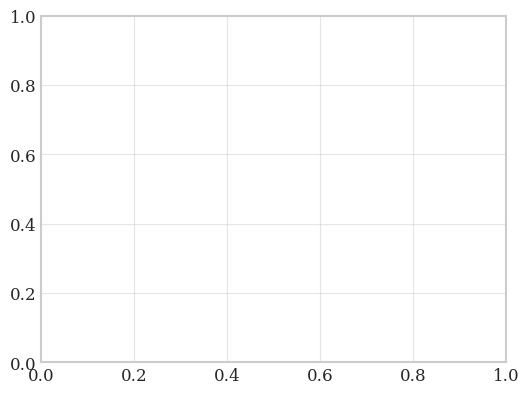

In [12]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4.5))

n=10; m=11


def latex_scientific_notation(value):
    exponent = int(np.log10(value))
    if exponent:
        value = value / 10**exponent
        return f"{value}" + r" \times 10^{" + str(exponent) +"}"
    return f"{value}"

sim_parms = simulations[1]["parms"]
sim1_parms_str = f"{sim_parms['m0']}, {sim_parms['chosen_depth']}, {latex_scientific_notation(sim_parms['eps'])}"
sim_parms = simulations[2]["parms"]
sim2_parms_str = f"{sim_parms['m0']}, {sim_parms['chosen_depth']}, {latex_scientific_notation(sim_parms['eps'])}"

# Adjusted plot with different shades and symbols for clarity
ax.plot(simulations[1]["times_act_ell"][:-1][::m],  simulations[1]["velocity_PS_ell"][::m], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str  +r') v_{\rm PS}=\Delta T^{-1}$', 
        color="magenta", linestyle='--', marker='^', linewidth=2)
ax.scatter(simulations[1]["times_act_ell"][:-1][::n], simulations[1]["velocity_mu_ell"][::n], 
           label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str  +r') v_{\mu}=\|{\cal G}^{-1}{\cal H}\|$', 
           color='lightcoral', linestyle='--', marker='o', linewidth=0.5)

ax.plot(simulations[2]["times_act_ell"][:-1][::n], simulations[2]["velocity_PS_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim2_parms_str  + r') v_{\rm PS}=\Delta T^{-1}$', 
        color="lightgreen", linestyle='dashdot', marker='*')
ax.scatter(simulations[2]["times_act_ell"][:-1][::n] , simulations[2]["velocity_mu_ell"][::n], 
           label=r'$(m_0, \ell, \epsilon) = (' + sim2_parms_str   + r') v_{\mu}=\|{\cal G}^{-1}{\cal H}\|$', 
           color='darkgreen', linestyle='--', marker='s', linewidth=0.5)

# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='center right')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0]*vLR, timespan[-1]*vLR)

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()

#plt.savefig('Velocity Comparison', format='pdf')
#plt.show()

#### Expectation values of observables

In [ ]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(8, 8))

n=1
ax.plot(timespan * vLR, evs_obs_ex, label='Exact', color="blue", linestyle='dashdot', linewidth=2)
ax.plot(timespan[::n] * vLR, simulations[1]["ev_obs_maxent_act_partialSum_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = (' + sim1_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='red', linestyle='--', marker='D', linewidth=0.5)
ax.plot(timespan[::n] * vLR, simulations[2]["ev_obs_maxent_act_partialSum_ell"][::n], 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim2_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='green', linestyle='--', marker='^', linewidth=0.5)
# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='upper left')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()

In [ ]:
werror_1 = [ sum(np.real(errors)**2)**.5   for errors in simulations[1]["instantaneous_w_errors"]]
werror_2 = [ sum(np.real(errors)**2)**.5   for errors in simulations[2]["instantaneous_w_errors"]]


fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(simulations[1]["times_act_ell"][::n] * vLR, werror_1, 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim1_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='red', linestyle='--', marker='D', linewidth=0.5)
ax.plot(simulations[2]["times_act_ell"][::n] * vLR, werror_2, 
        label=r'$(m_0, \ell, \epsilon) = ('+ sim2_parms_str +r'), $ Adap. Max-Ent - Partial Sum', color='green', linestyle='--', marker='^', linewidth=0.5)
ax.legend()
# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax.set_ylabel(r'$|{\cal W}|$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Adjustment final et affichage
plt.tight_layout()